[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12BW8URdfHMTbbfmoja4tEoQJXZA_ozIJ?usp=sharing)

# **Libraries**

In [1]:
# Import dependencies
from google.colab import files ## Upload file(s) from local
import zipfile ## Unzip zip file(s)
import os ## Interact with file system
import shutil ## Copy file(s)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import random

# **Data Preparation**

[Cassava Dataset from Kaggle](https://www.kaggle.com/datasets/anaselmasry/cassava-leaf-disease-classification-v2)

Download the dataset using Kaggle API, the official documentation [here](https://www.kaggle.com/docs/api).

In [ ]:
# Set Kaggle API
## Installation
! pip install kaggle

## Upload Kaggle API token (.json format) from user's profile 'Create API Token'
files.upload() ### Upload files button appears for import the .json file from local 

## Create a folder for specific Kaggle API location
! mkdir ~/.kaggle

## Copy the uploaded API token to the created folder
! cp kaggle.json ~/.kaggle/

## Modify file permission and ensure user's credential security
! chmod 600 ~/.kaggle/kaggle.json 

Saving kaggle.json to kaggle.json


In [ ]:
# Create a helper function to unzip file(s)
def unzip(zipfile_name_list):
  """
  Params:
          zipfile_name_list: List contains zipfile name without .zip extensions
  """
  ## Iterate over passed list
  for file in zipfile_name_list:
    ## Merge zipfile name with .zip extension
    file_zip = str(file) + '.zip'
    ## Try open zipfile with read 'r' mode
    try:
      zip_ref = zipfile.ZipFile(file_zip, 'r')
    except:
      print("Something went wrong when read to the unzip file")
    ## Extract readed zipfile by pass the destination path
    zip_ref.extractall('./' + file + '/')
    ## Close read mode
    zip_ref.close()

# Create a function to download and unzip Kaggle dataset by passed its webpage address link
def download_and_unzip_dataset(*dataset_link):
  """
  Params:
          *dataset_link: Kaggle dataset link(s) separate with commas and enclosed by string
  """
  ## Create empty list to collect zipfile name
  zipfile_name = [] 
  ## Iterate over passed Kaggle dataset link/address
  for link in dataset_link:
    ## Split address by forward slash
    slash_split = str(link).split('/')
    ## Set conditions to provide datasets download from either Kaggle regular datasets or competitions webpage
    if slash_split[-3] != 'datasets' and slash_split[-3] != 'competitions':
      ## Raise exception error if addresses are not as expected Kaggle webpage address format
      raise Exception('Link(s) format are not as expected')
    ## Set conditions for Kaggle regular datasets download
    if slash_split[-3] == 'datasets':
      ## Construct a formatted dataset name
      dataset_name = slash_split[-2] + '/' + slash_split[-1]
      ## Do bash command to download datasets
      ! kaggle datasets download $dataset_name
    ## Set conditions for Kaggle competitions datasets download
    if slash_split[-3] == 'competitions':
      ## Construct a formatted dataset name
      dataset_name = slash_split[-2]
      ## Do bash command to download datasets
      ! kaggle competitions download -c $dataset_name 
    ## Append last split space as zipfile name
    zipfile_name.append(slash_split[-1])
  ## Execute the created helper function to unzip downloaded file(s)
  unzip(zipfile_name)

In [ ]:
# Download the appropriate dataset(s) by pass its Kaggle webpage link to the created function 
## Download the Cassava leaf dataset from Kaggle
download_and_unzip_dataset('https://www.kaggle.com/datasets/anaselmasry/cassava-leaf-disease-classification-v2')

 99% 159M/161M [00:02<00:00, 98.0MB/s]
100% 161M/161M [00:02<00:00, 80.0MB/s]


In [ ]:
# Copy image class(es) to appropriate folder also the class name that are desired 
def move_image(src_dir, classname_list, destination_root_dir):
  """
  Params:
          src_dir: Root directory of source, enclosed by string
          classname_list : List contains desired name of class(es), ordered alphabetically
          destination_root_dir : Root directory of destination
  """ 
  ## Ensure the destination root directory is exist
  if not os.path.exists(destination_root_dir):
    ## Create if doesn't exist
    os.makedirs(destination_root_dir)
  ## Create source classname list which is alphabetically sorted  
  class_src = sorted([dirs for root, dirs, files in os.walk(src_dir)][0])
  ## Iterate over passed classname_list index
  for index in range(len(classname_list)):
    ## Ensure the desired classname in destination root directory is exist
    if os.path.exists(os.path.join(destination_root_dir, str(classname_list[index]))):
      ## Create if doesn't exist
      os.makedirs(os.path.join(destination_root_dir, str(classname_list[index])))
    ## Ensure the number of source and desired classes are equal 
    if len(class_src) == len(classname_list):
      ## Copy each class directory
      shutil.copytree(os.path.join(src_dir, str(class_src[index])),
                      os.path.join(destination_root_dir, str(classname_list[index])))
    ## Set condition the number of source and desired classes are not equal 
    else:
      ## Raise an exception
      raise Exception("Number of directories not equal between source and destination")

In [ ]:
# Define desired classname
cassavaleaf_classname = ['Cassava Bacterial Blight (CBB)', 
                         'Cassava Brown Steak Disease (CBSD)',
                         'Cassava Green Mite (CGM)',
                         'Cassava Mosaic Disease (CMD)',
                         'Health']

# Define root directories, both source and destination
src_dir = '/content/cassava-leaf-disease-classification-v2'
root_dir = '/tmp/Data'

# Empty root directory to prevent FileExistsError when run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# Execute defined function to copy image class(es)
move_image(src_dir, cassavaleaf_classname, root_dir)

# **Exploratory Data Analysis**

In [ ]:
def simple_eda(data_dir):
  """
  Params:
              
  """ 
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  class_num = len(class_list)
  print("There are {} classes with various number of images for each".format(class_num))

  images_num = []
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    images_num.append(len(os.listdir(class_dir)))
    print("\n - {} : {} images".format(each_class, len(os.listdir(class_dir))))

  plt.figure(figsize=(8, 6))
  ax = plt.subplot()
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  plt.bar(class_list, images_num, zorder=3)
  plt.grid(zorder=0)
  plt.title("Images Distribution", fontsize=20)
  plt.xlabel("Classes/Categories", fontsize=12)
  plt.show()

def display_sample(data_dir, num_sample):
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    plt.figure(figsize=(100/num_sample, 4))
    print("\nLabel: {}".format(each_class))
    for index, image_path in enumerate(os.listdir(class_dir)[:num_sample]):
        ax = plt.subplot(1, num_sample, index+1)
        image = mpimg.imread(os.path.join(class_dir, image_path))
        ax.grid()
        plt.imshow(image)
    plt.show()

There are 5 classes with various number of images for each

 - Cassava Bacterial Blight (CBB) : 1087 images

 - Cassava Brown Steak Disease (CBSD) : 2189 images

 - Cassava Green Mite (CGM) : 2386 images

 - Cassava Mosaic Disease (CMD) : 1488 images

 - Health : 2577 images


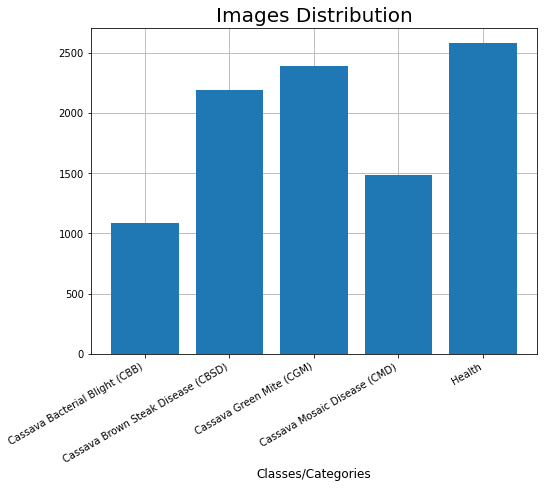

In [ ]:
simple_eda(root_dir)


Label: Cassava Bacterial Blight (CBB)


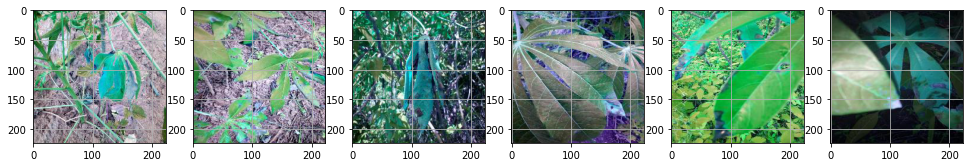


Label: Cassava Brown Steak Disease (CBSD)


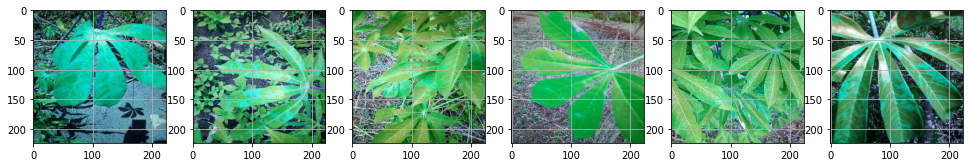


Label: Cassava Green Mite (CGM)


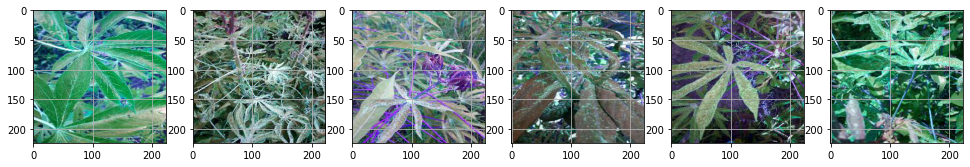


Label: Cassava Mosaic Disease (CMD)


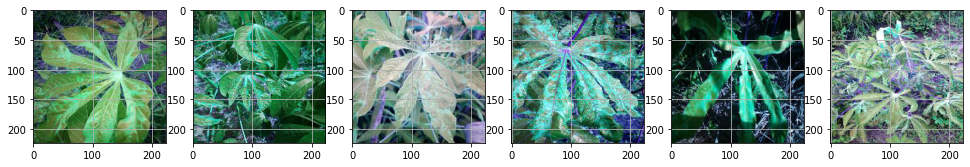


Label: Health


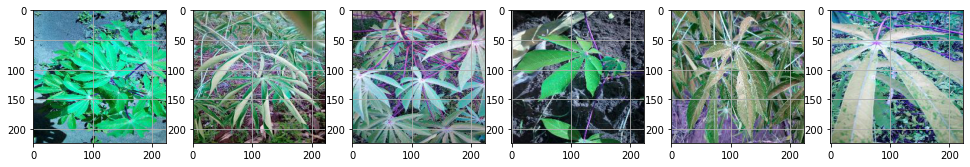

In [ ]:
display_sample(root_dir, num_sample=6)

# **Data Split**

In [ ]:
def split_class_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
  """
  Params:
              
  """ 
  for dir in [TRAINING, VALIDATION, TESTING]:
    if not os.path.exists(dir):
      os.makedirs(dir)

  if SPLIT_SIZE > 1 or SPLIT_SIZE < 0:
    raise Exception('split size should be between 0 and 1')

  train_val_len = int(len(os.listdir(SOURCE)) * SPLIT_SIZE)
  for index, file in enumerate(os.listdir(SOURCE)): 
    if index < train_val_len:
      if index < int(.95 * train_val_len):
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TRAINING)))
      else:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(VALIDATION)))
    else:
      shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TESTING)))

def display_distribution(DIR, split_type=['Train', 'Validation', 'Test']):
  """
  Params:
                  
  """ 
  user_input_type = [split_type]
  type_list = ['Train', 'Validation', 'Test']
  if len(user_input_type) > 1:
    raise Exception("Please choose one type of split")
  if user_input_type[0] not in type_list:
    raise Exception("Please choose a type of split that provided; \'Train\', \'Validation\', or \'Test\'")
  
  print("\n{}".format(user_input_type[0]))
  for dir_class in sorted(os.listdir(DIR)):
    print('{}: {} images'.format(dir_class, len(os.listdir(os.path.join(DIR, dir_class)))))

In [ ]:
# Create appropriate directories corresponds to Train, Validation, and Test split
## Set root directory of split data
root_split_dir = '/tmp/Split'

## Empty root directory to prevent FileExistsError when run several times
if os.path.exists(root_split_dir):
  shutil.rmtree(root_split_dir)

## Set each type of data split
train_split_dir = os.path.join(root_split_dir, 'Train')
validation_split_dir = os.path.join(root_split_dir, 'Validation')
test_split_dir = os.path.join(root_split_dir, 'Test')

## Set train directories each class
cbb_train_dir = os.path.join(train_split_dir, cassavaleaf_classname[0])
cbsd_train_dir = os.path.join(train_split_dir, cassavaleaf_classname[1])
cgm_train_dir = os.path.join(train_split_dir, cassavaleaf_classname[2])
cmd_train_dir = os.path.join(train_split_dir, cassavaleaf_classname[3])
health_train_dir = os.path.join(train_split_dir, cassavaleaf_classname[4])

## Set validation directories each class
cbb_validation_dir = os.path.join(validation_split_dir, cassavaleaf_classname[0])
cbsd_validation_dir = os.path.join(validation_split_dir, cassavaleaf_classname[1])
cgm_validation_dir = os.path.join(validation_split_dir, cassavaleaf_classname[2])
cmd_validation_dir = os.path.join(validation_split_dir, cassavaleaf_classname[3])
health_validation_dir = os.path.join(validation_split_dir, cassavaleaf_classname[4])

## Set test directories each class
cbb_test_dir = os.path.join(test_split_dir, cassavaleaf_classname[0])
cbsd_test_dir = os.path.join(test_split_dir, cassavaleaf_classname[1])
cgm_test_dir = os.path.join(test_split_dir, cassavaleaf_classname[2])
cmd_test_dir = os.path.join(test_split_dir, cassavaleaf_classname[3])
health_test_dir = os.path.join(test_split_dir, cassavaleaf_classname[4])

## Pass source directories each class before do split data
cbb_source_dir = os.path.join(root_dir, cassavaleaf_classname[0])
cbsd_source_dir = os.path.join(root_dir, cassavaleaf_classname[1])
cgm_source_dir = os.path.join(root_dir, cassavaleaf_classname[2])
cmd_source_dir = os.path.join(root_dir, cassavaleaf_classname[3])
health_source_dir = os.path.join(root_dir, cassavaleaf_classname[4])

## Define split size between training-validation and test set
split_size = .999

## Execute split_class_data function to split data into Train, Validation, and Test set for each class
split_class_data(cbb_source_dir, cbb_train_dir, cbb_validation_dir, cbb_test_dir, split_size)
split_class_data(cbsd_source_dir, cbsd_train_dir, cbsd_validation_dir, cbsd_test_dir, split_size)
split_class_data(cgm_source_dir, cgm_train_dir, cgm_validation_dir, cgm_test_dir, split_size)
split_class_data(cmd_source_dir, cmd_train_dir, cmd_validation_dir, cmd_test_dir, split_size)
split_class_data(health_source_dir, health_train_dir, health_validation_dir, health_test_dir, split_size)

## Execute display_distribution function
print('[Split Distribution]')
display_distribution(train_split_dir, split_type='Train')
display_distribution(validation_split_dir, split_type='Validation')
display_distribution(test_split_dir, split_type='Test')

[Split Distribution]

Train
Cassava Bacterial Blight (CBB): 1030 images
Cassava Brown Steak Disease (CBSD): 2076 images
Cassava Green Mite (CGM): 2263 images
Cassava Mosaic Disease (CMD): 1411 images
Health: 2445 images

Validation
Cassava Bacterial Blight (CBB): 55 images
Cassava Brown Steak Disease (CBSD): 110 images
Cassava Green Mite (CGM): 120 images
Cassava Mosaic Disease (CMD): 75 images
Health: 129 images

Test
Cassava Bacterial Blight (CBB): 2 images
Cassava Brown Steak Disease (CBSD): 3 images
Cassava Green Mite (CGM): 3 images
Cassava Mosaic Disease (CMD): 2 images
Health: 3 images


# **Data Augmentation & Generator**

In [ ]:
def display_augmentation(IMG_PATH, ROTATION_RANGE, WIDTH_SHIFT_RANGE, 
                         HEIGHT_SHIFT_RANGE, SHEAR_RANGE, ZOOM_RANGE):
  """
  Params:
          
  """ 
  image = load_img(IMG_PATH)
  image_array = img_to_array(image)
  image_exp = np.expand_dims(image_array, 0)

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=ROTATION_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_rotate = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=WIDTH_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_width_shift = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     height_shift_range=HEIGHT_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_height_shift = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     shear_range=SHEAR_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_shear = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=ZOOM_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_zoom = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_horizontal_flip = batch[0]

  fig = plt.figure(figsize=(10, 7))
  rows = 2
  cols = 4
  augmented_images = [0, image, image_rotate, image_width_shift, image_height_shift, image_shear, image_zoom, image_horizontal_flip]
  plt_title = [0, "Real Image", "Rotation", "Width Shift", "Height Shift", "Shear", "Zoom", "Horizontal Flip"]
  for index in range(len(augmented_images)):
    if index == 0:
      continue
    fig.add_subplot(rows, cols, index)
    plt.imshow(augmented_images[index])
    plt.axis('off')
    plt.title(plt_title[index])

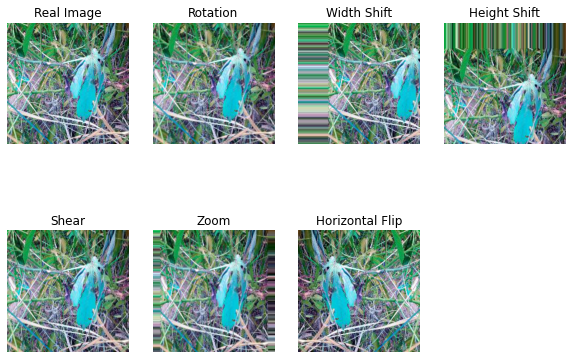

In [ ]:
# Get a random image from one particular class
random_image = random.choice(os.listdir(cbb_train_dir))
rotation_range = 40
width_shift_range = .3
height_shift_range = .3
shear_range = .4
zoom_range = .2
display_augmentation(os.path.join(cbb_train_dir, random_image),
                     rotation_range,
                     width_shift_range,
                     height_shift_range,
                     shear_range,
                     zoom_range)

In [ ]:
# Define a Train and Validation set function
def train_val_generator(TRAINING_DIR, VALIDATION_DIR, 
                         TARGET_SIZE, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE):
  """
  Params:
          
  Returns:

  """ 
  ## Instantiate the ImageDataGenerator class with images augmentation
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=90,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2,
                                     zoom_range=.2,
                                     horizontal_flip=True)

  ## Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=TRAIN_BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=TARGET_SIZE)

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=VAL_BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=TARGET_SIZE)
  return train_generator, validation_generator

In [ ]:
# Set batch size and target image size
train_batch_size = 32
val_batch_size = 20
target_size = (150, 150)

# Get train and validation data generator
train_generator, validation_generator = train_val_generator(train_split_dir,
                                                            validation_split_dir,
                                                            target_size,
                                                            train_batch_size,
                                                            val_batch_size)

Found 9225 images belonging to 5 classes.
Found 489 images belonging to 5 classes.


In [ ]:
print("Train Generator code for each class \n{}".format(train_generator.class_indices))
print("\n Validation Generator code for each class \n{}".format(validation_generator.class_indices))

Train Generator code for each class 
{'Cassava Bacterial Blight (CBB)': 0, 'Cassava Brown Steak Disease (CBSD)': 1, 'Cassava Green Mite (CGM)': 2, 'Cassava Mosaic Disease (CMD)': 3, 'Health': 4}

 Validation Generator code for each class 
{'Cassava Bacterial Blight (CBB)': 0, 'Cassava Brown Steak Disease (CBSD)': 1, 'Cassava Green Mite (CGM)': 2, 'Cassava Mosaic Disease (CMD)': 3, 'Health': 4}


# **Model Architecture**

In [ ]:
# Create a simple CNN architecture
def create_model(TARGET_SIZE):
  """
  Params:
          
  Returns:

  """ 
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                             input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax', name="predict_class")
  ])

  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    
  return model

In [ ]:
# Get the model architecture by pass target_size defined before
model = create_model(target_size)

# Get model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 64)      

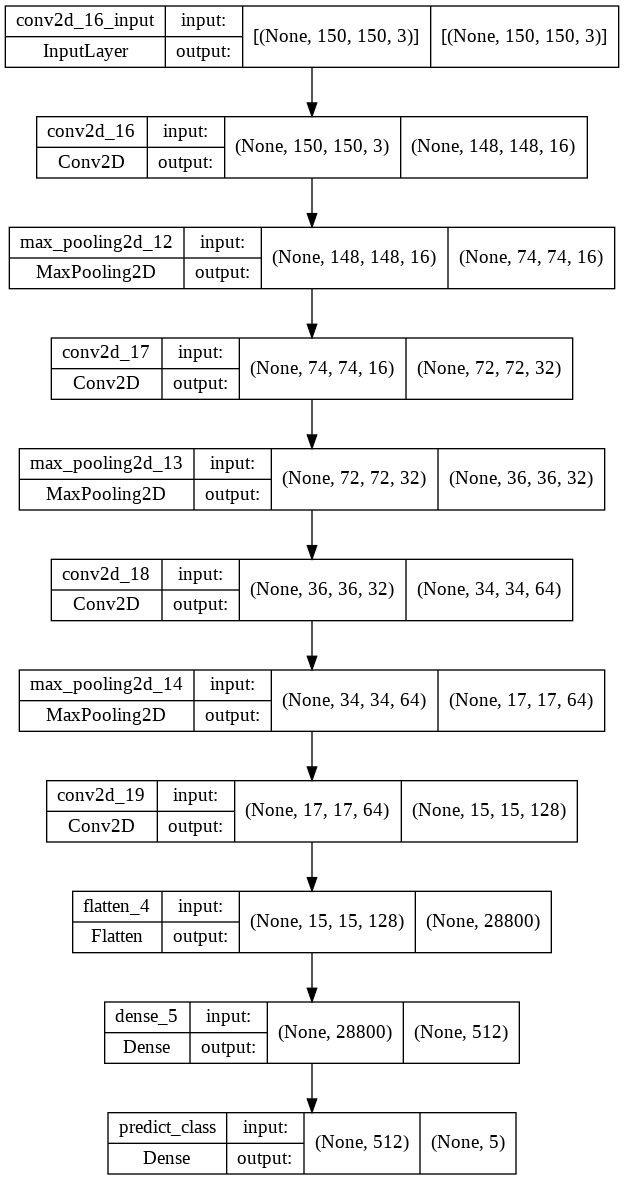

In [ ]:
# plot the model architecture
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
)

# **Train the Model**

In [ ]:
# Callbacks schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check
    if logs.get('accuracy') > .99 and logs.get('val_accuracy') > .99:

      # Stop if threshold is met
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

    # Get learning rate callbacks
    #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Instantiate class
callbacks = myCallback()

# Create simple early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# Model checkpoint
model_checkp = tf.keras.callbacks.ModelCheckpoint('model_v1_checkp.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [ ]:
# Train the model
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=int(train_generator.samples/train_batch_size),
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=int(validation_generator.samples/val_batch_size),
                    callbacks=[callbacks, early_stop, model_checkp])